In [1]:
import sys
sys.path.append("../src")
import tifffile
import torch
import numpy as np
from itertools import product
from pathlib import Path
from typing import Tuple, List
from skimage.util import view_as_windows
from semantic_bac_segment.pre_processing import ImageAdapter
from semantic_bac_segment.models.pytorch_altmodel import UNET
from semantic_bac_segment.segmentator import Segmentator, Segmentator2
from semantic_bac_segment.utils import normalize_percentile, get_device, empty_gpu_cache


In [3]:

img = tifffile.imread('../data/source_norm/mabs_img_4.tiff')


In [7]:

model_path = "../data/models/state_weights/unet_model_test_2_best_model.pth"
bac_seg_monai=Segmentator2(model_path, UNET(), patch_size=128, overlap_ratio=0.0, half_precision=True)


In [8]:
output=bac_seg_monai.predict(img)

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x333c0a430>)

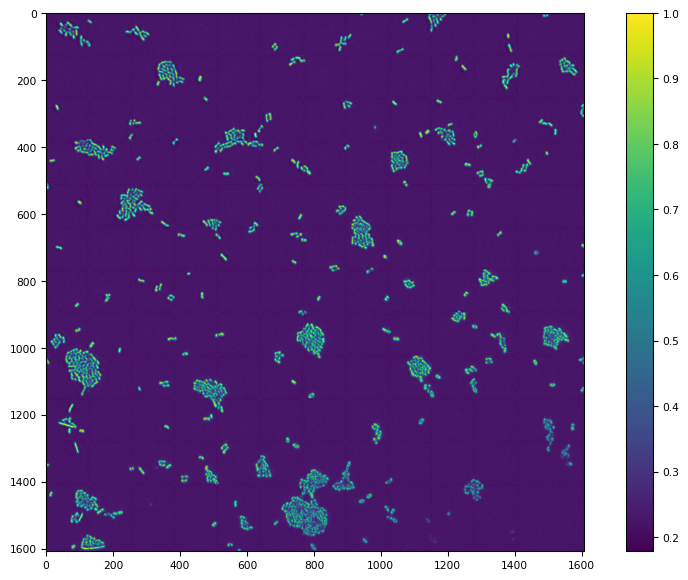

In [9]:
def sigmoid(z):
    """Sigmoid function for numpy arrays"""
    return 1 / (1 + np.exp(-z))
tifffile.imshow(np.power(sigmoid(output), 0.5))

In [50]:
model_path = "../data/models/state_weights/unet_model_test_2_best_model.pth"
bac_seg=Segmentator(model_path, UNET(), patch_size=128, overlap_ratio=0.0, half_precision=True)


In [51]:
output=bac_seg.predict(img)
tifffile.imshow(np.power(output, 0.5))

In [94]:
import torch
import torch.nn.functional as F

def add_laplacian_channel(image):
    """
    Add a third channel to an image with Laplacian edge detection.

    Args:
        image (torch.Tensor): Input image tensor.

    Returns:
        torch.Tensor: Image tensor with an additional Laplacian edge detection channel.
    """
    laplacian = torch.tensor([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]).to(image)

    laplacian = laplacian.view((1, 1) + laplacian.size())

    edge = F.conv2d(image, laplacian, padding=1)

    return edge


def add_edge_channel(image):
    """
    Add a third channel to an image with Sobel edge detection.

    Args:
        image (torch.Tensor): Input image tensor.

    Returns:
        torch.Tensor: Image tensor with an additional Sobel edge detection channel.
    """
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).to(image)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]).to(image)

    sobel_x = sobel_x.view((1, 1) + sobel_x.size())
    sobel_y = sobel_y.view((1, 1) + sobel_y.size())

    edge_x = F.conv2d(image, sobel_x, padding=1)
    edge_y = F.conv2d(image, sobel_y, padding=1)

    edge = torch.sqrt(edge_x**2 + edge_y**2)

    return edge


def add_maxedge_channel(image):
    """
    Add a third channel to an image with Sobel edge detection.

    Args:
        image (torch.Tensor): Input image tensor.

    Returns:
        torch.Tensor: Image tensor with an additional Sobel edge detection channel.
    """
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).to(image)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]).to(image)

    sobel_x = sobel_x.view((1, 1) + sobel_x.size())
    sobel_y = sobel_y.view((1, 1) + sobel_y.size())

    edge_x = F.conv2d(image, sobel_x, padding=1)
    edge_y = F.conv2d(image, sobel_y, padding=1)
    edge = torch.sqrt(edge_x**2 + edge_y**2)

    # Calculate the Sobel filter on the inverse image
    inverse_image = 1 - image
    edge_x_inverse = F.conv2d(inverse_image, sobel_x, padding=1)
    edge_y_inverse = F.conv2d(inverse_image, sobel_y, padding=1)
    edge_inverse = torch.sqrt(edge_x_inverse**2 + edge_y_inverse**2)

    # Take the maximum of the edge images
    max_edge = torch.max(edge, edge_inverse)

    return torch.cat([image, max_edge], dim=1)

In [95]:
img = tifffile.imread('../data/source_norm/img_2.tiff')


In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming img is a numpy array
img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).float()

# Apply the function
img_with_edge = add_edge_channel(img_tensor)
img_max_edge=add_maxedge_channel(img_tensor)
img_lap= add_laplacian_channel(img_tensor)
# Convert back to numpy
img_with_edge_np = img_with_edge.squeeze(0).unsqueeze(0).numpy()
img_lap_np=img_lap.squeeze(0).unsqueeze(0).numpy()

In [92]:
img_with_edge_np=img_with_edge_np[0, 1]
img_lap_np=img_lap_np[0, 1]

In [98]:
img_with_edge_np=img_with_edge_np[0, 0]
img_lap_np=img_lap_np[0, 0]

In [100]:
print(f'shape of img with edge{img_with_edge_np.shape}')
print(f'shape of img lap{img_lap_np.shape}')

shape of img with edge(1608, 1608)
shape of img lap(1608, 1608)


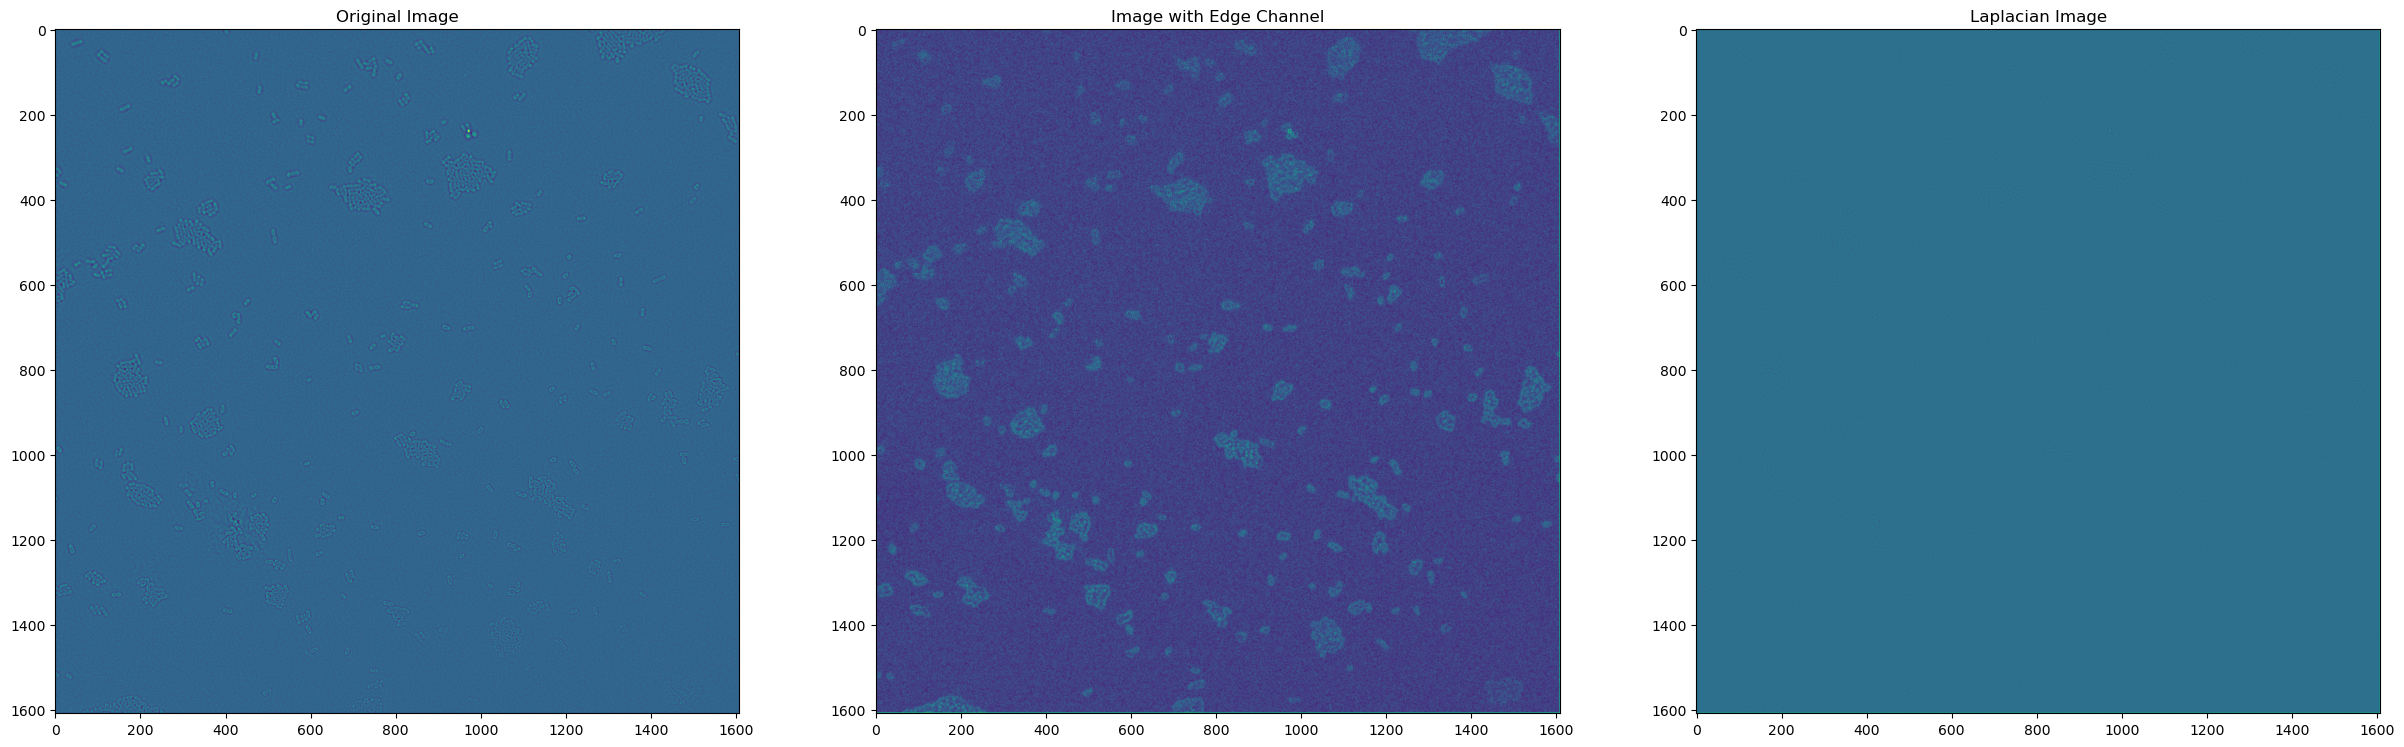

In [101]:
from PIL import Image, ImageOps
import numpy as np
plt.figure(figsize=(30, 10))  # Increase the figure size

plt.subplot(1, 3, 1)  # Change the second parameter to 3
plt.imshow(np.power(img, 2), cmap='viridis')
plt.title('Original Image')

plt.subplot(1, 3, 2)  # Change the second parameter to 3
plt.imshow(np.power(img_with_edge_np, 0.5), cmap='viridis')
plt.title('Image with Edge Channel')

plt.subplot(1, 3, 3)  # Add this block for the third plot
plt.imshow(np.power(img_lap_np*5+10, 0.95), cmap='viridis')
plt.title('Laplacian Image')

plt.show()

In [69]:
img_with_edge_np.shape

(2400, 2400)

In [102]:
tifffile.imwrite('../data/test_sob.tiff', img_with_edge_np)
tifffile.imwrite('../data/test_lap.tiff', img_lap_np)